# <div style="text-align: center; color: cyan">Generalization</div>

## <div style="text-align: center; color: lime">Setup</div>

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

## <div style="text-align: center; color: lime">Imports</div>

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision import transforms

import keras
from keras import layers
from keras.applications import MobileNetV2

import kagglehub

import datetime

## <div style="text-align: center; color: lime">Load the data</div>

In [3]:
path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

data_path = Path(path) / "tom_and_jerry/tom_and_jerry"

trs = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

all_data = ImageFolder(data_path, transform=trs)

g1 = torch.Generator().manual_seed(20)
train_data, val_data, test_data = random_split(all_data, [0.7, 0.2, 0.1], g1)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
val_loader = DataLoader(val_data, batch_size=12, shuffle=False)
test_loader = DataLoader(test_data, batch_size=12, shuffle=False)

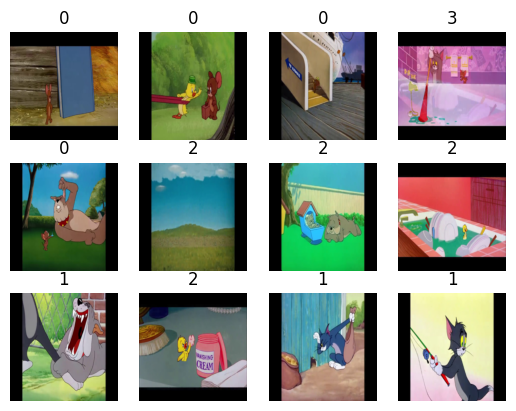

In [4]:
fig, axes = plt.subplots(3, 4)

axes_ravel = axes.ravel()

for images, labels in train_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        axes_ravel[i].imshow(transforms.ToPILImage()(image))
        axes_ravel[i].set_axis_off()
        axes_ravel[i].set_title(f"{label}")
    break

## <div style="text-align: center; color: lime">Make the model</div>

In [5]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Permute((2, 3, 1)),
        base_model,
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute (Permute)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


## <div style="text-align: center; color: lime">Train the model</div>

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader,
    callbacks=[tensorboard_callback],
)

Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.4240 - loss: 8.9304 - val_accuracy: 0.3449 - val_loss: 10.2735
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - accuracy: 0.5142 - loss: 7.5371 - val_accuracy: 0.5046 - val_loss: 7.7399
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.5810 - loss: 6.4474 - val_accuracy: 0.5538 - val_loss: 6.9362
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.6430 - loss: 5.5279 - val_accuracy: 0.6223 - val_loss: 5.8011
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.6860 - loss: 4.8473 - val_accuracy: 0.6423 - val_loss: 5.6132


## <div style="text-align: center; color: lime">Evalute the model</div>

In [12]:
loss, accuracy = model.evaluate(test_loader)

print("loss:", loss)
print("accuracy:", accuracy)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.6417 - loss: 5.3892
loss: 5.389165878295898
accuracy: 0.6416819095611572


## <div style="text-align: center; color: lime">Plot the training procedure</div>

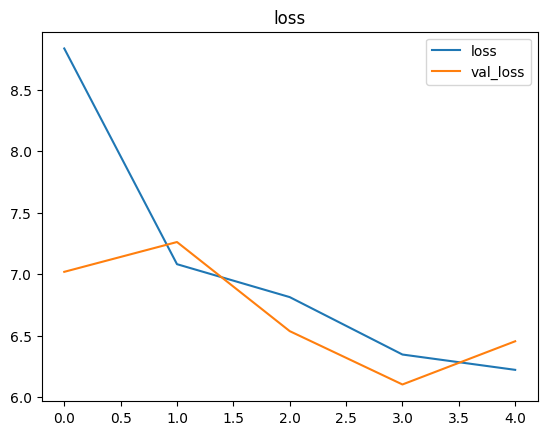

In [13]:
plt.figure()
plt.title("loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

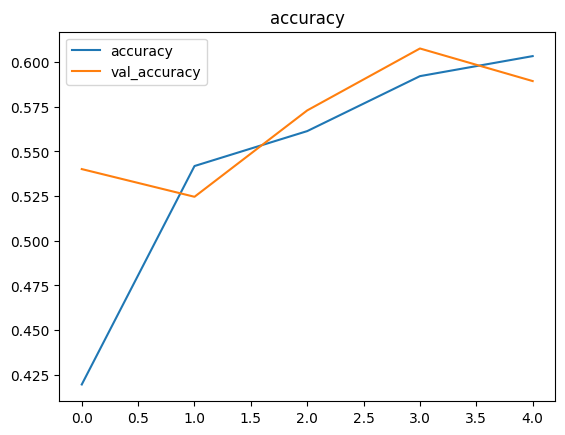

In [14]:
plt.figure()
plt.title("accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

<p style="text-align: center; font-family: "Trebuchet MS", sans-serif; color: #888; font-size: 0.9em; margin-top: 2em; border-top: 1px solid #ccc; padding-top: 0.5em;">
    @LiterallyTheOne — PhD Candidate in Artificial Intelligence
</p>

<div style="text-align: center">
<a style="margin: 1em" href="https://literallytheone.github.io">https://literallytheone.github.io</a>
</div>
